<a href="https://colab.research.google.com/github/brijk7/python-docs-samples/blob/main/people-and-planet-ai/rain-nowcasting/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# 🏭 Rain forecasting with satellite imagery

* **Time estimate**: 1 hour
* **Cost estimate**: less than $**5**.00 USD

This is an interactive notebook that contains all the code necessary to train an ML model from satellite images for forecasting precipitation - both the probability of rain and the amount of rainfall in the next hour. The purpose of this notebook is to be demonstrative rather than accurate.

--------------------------------------------


💚 This is one of many **machine learning how-to samples** inspired from **real climate solutions** aired on the [People and Planet AI 🎥 series](https://www.youtube.com/playlist?list=PLIivdWyY5sqI-llB35Dcb187ZG155Rs_7).

# 🚏 Overview

This notebook leverages geospatial satellite and precipitation data from [Google Earth Engine](https://earthengine.google.com/). Using this satellite imagery, you'll build and train a model for rain "nowcasting" i.e. predicting the probability and amount of rainfall for a given location within the next hour.

### 🛰️ Data _(inputs)_

The data in this example consists of images from a satellite called [GOES-16](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_MCMIPF?hl=en), a [TODO: add description of GOES-16].

When working with satellite data, each input image has the dimensions `[width, height, bands]`. **Bands** are measurements from specific satellite instruments for different ranges of the electromagnetic spectrum. For example, GOES-16 captures [🌈 16 spectral bands](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_MCMIPF?hl=en#bands). 

If you're familiar with image classification problems, you can think of the bands as similar to an image's RGB (red, green, blue) channels. However, when working with satellite data we generally have more than just 3 channels, in this case 16 channels.

In this specific example, we also need to consider multiple images across time, since weather forecasting is more accurate if we look at how the cloud cover changes over a period of time. Particularly, we will consider 3 timestamps - 60 minutes prior, 30 minutes prior, and now. We will extract satellite images for each timestamp. Our input dataset has the shape `[width, height, bands * 3 timepoints]`. 

### 🏷️ Labels _(outputs)_

For each geospatial **region** and **timestamp** that we provide as input to the model, it performs **binary classification** to predict if it is going to rain in that region or not, and **linear regression** to predict the amount of rainfall, both over the next hour.

In this example, the **output** is two numbers:

* a value between *0 (no rain) and 1 (rain)*, representing the **probability** of rain.
* a value greater than 0, representing the **amount** of predicted rainfall in mm/hr.

These labels are obtained from the Global Precipitation Map [dataset](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V06?hl=en).

### 🧠 Model _(function)_

As described above, our overall prediction function looks like this:
```
rain_probability, rain_amount = predict(location, timestamp)
```

The model will construct an image patch (33x33x16x3) corresponding to the location to forecast rain for. The image patch is created by taking a single pixel corresponding to the location, padding 16 pixels on all sides, and then extracting the satellite imagery and precipitation data for that region for 3 prior timestamps (-60 mins, -30 mins, now). In pseudo-code:
```
predict(location, timestamp):
  region = pad(location, 16px)
  timestamps = [timestamp-60m, timestamp-30m, timestamp]
  imagedata = earth_engine.extract(region, timestamps)
  rain_prb_for_next_hour, rain_amt_for_next_hour = rain_model.predict(imagedata) 
```

To do the above, the model must first be built by training on labeled satellite image data. The training data is constructed by taking small square regions of satellite image data over a period of an hour, and labeling them with observed precipitation. We'll prepare this dataset from Earth Engine. The image data is obtained from the GOES-16 [dataset](https://developers.google.com/earth-engine/datasets/catalog/NOAA_GOES_16_MCMIPF?hl=en).

![training](img/training.png)


## 🚴‍♀️ Steps summary

Here's a quick summary of what you’ll go through:

1. **Get the training data**:
  Extract precipitation data and corresponding satellite images from [Earth Engine](https://earthengine.google.com/), and export it to
  [Cloud Storage](https://cloud.google.com/storage) in TFRecord format.

1. **Train the model with Vertex AI**:
  Using [Tensorflow Keras](https://keras.io/) on [Vertex AI Training](https://cloud.google.com/vertex-ai/docs/training/custom-training) using a [pre-built training container](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers).

1. **Deploy a service to host the trained model**:
  On
  [Cloud Run](https://cloud.google.com/run)
  and get predictions using the model.

1. **Get Predictions**:
  Use the web service to get predictions for new data.

1. **Visualize predictions**:
  Visualize the predictions on a map.

1. (Optional) **Delete the project** to avoid ongoing costs.

## 🙈 Using this interactive notebook

Click the **run** icons ▶️ of each section within this notebook. 

This notebook code lets you train and deploy an ML model from end-to-end. When you run a code cell, the code runs in the notebook's runtime, so you're not making any changes to your personal computer.

> 🛎️ **To avoid any errors**, wait for each section to finish in their order before clicking the next “run” icon.

This sample must be connected to a **Google Cloud project**, but nothing else is needed other than your Google Cloud project.
You can use an existing project and the cost will be less than **$5.00**. Alternatively, you can create a new Cloud project with cloud credits for free.

# ✨ Setup

1. Decide on creating a new
   [free project](https://cloud.google.com/free/docs/gcp-free-tier)
   _(recommended)_ or using an existing one.
   Then **copy the project ID** and paste it in the `google_cloud_project` field in the "Entering project details” section below.

   > 💡 If you _don't plan to keep the resources_ that you create via this sample, we recommend creating a new project instead of selecting an existing project.
   > After you finish these steps, you can delete the project, removing all the resources associated in bulk.

1. [_Click here_](https://console.cloud.google.com/flows/enableapi?apiid=dataflow,aiplatform.googleapis.com)
   to **enable the following APIs** in your Google Cloud project:
   _Dataflow_ and _AI Platform_.

1. Make sure that **billing is enabled** for your Google Cloud project,
   [_click here_](https://cloud.google.com/billing/docs/how-to/modify-project)
   to learn how to confirm that billing is enabled.

1. Have an **Earth Engine** account (it's FREE) or create a new one.
  To create an account, fill out this [registration form](https://signup.earthengine.google.com/#!/). Please note this can take from 0-24 hours...but it's worth it! Come back to this sample after you have this.

### ⛏️ Preparing the project environment

Click the run ▶️ icons in order for the cells to download and install the necessary code, libraries, and resources for this solution.

> 💡 You can _optionally_ view the entire
> [code in GitHub](https://github.com/GoogleCloudPlatform/python-docs-samples/tree/main/people-and-planet-ai/geospatial-classification).

### ↘️ Get the code

In [ ]:
# Get the sample source code.

# TODO: enable
#!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
#%cd python-docs-samples/people-and-planet-ai/rain-forecasting

### ✏️ Enter your Cloud project's details. Ensure you provide a regional bucket!

In [1]:
#@title My Google Cloud resources
project = 'brijk-play' #@param {type:"string"}
bucket = 'brijk-ppai' #@param {type:"string"}
region = 'us-central1' #@param {type:"string"}

# Validate the inputs.
if not project:
  raise ValueError(f"Please provide a value for 'project'")
if not bucket:
  raise ValueError(f"Please provide a value for 'bucket'")
if not region:
  raise ValueError(f"Please provide a value for 'region'")

# Authenticate
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

!gcloud config set project {project}

Authenticated
Updated property [core/project].


### 🗺️ Authenticate to Earth Engine

In [2]:
import ee
import google.auth
import tensorflow as tf
import random
import numpy as np

credentials, _ = google.auth.default()
ee.Initialize(credentials, project=project)

# 1. 🛰️ Get the training data

The training data in this sample is driven by a CSV file that's included. Each line in the CSV file contains a location (lat/long), a timestamp, a precipitation probability, and a precipitation amount (mm/hr). The last 2 fields are the labels. 

For each row in the CSV file, we need to extract the corresponding GOES-16 satellite image taken at that specific latitude/longitude and timestamp. We'll export this image data, along with the corresponding precipitation labels, to a Google Cloud Storage bucket. That shall then become the training and validation dataset for our model.

In [3]:
# Define constants
GOES_PADDING = 32
GPM_PADDING = 16
# image scale in meters
# GOES images have a raw resolution of 2000m, while GPM images are at 11132m
IMAGE_SCALE = 11132
CONFIG = 'p64_s11132'

LABEL1 = 'HQprecipitation'                       # amount of rain in mm/hr
LABEL2 = 'probabilityLiquidPrecipitation'        # probability of rain [0,100]
GOES_BANDS = [f'CMI_C{i:02d}' for i in range(1,17)]

# 16 bands * 3 timestamps
BANDS = [f'T{t}_CMI_C{i:02d}' for t in [0,1,2] for i in range(1,17)]

# we will focus on the US landmass region
regionUSA = ee.Geometry.Polygon(
        [[[-123.1931640625, 48.15710935359644],
          [-123.1931640625, 33.05264590094408],
          [-79.68730468750002, 33.05264590094408],
          [-79.68730468750002, 48.15710935359644]]], None, False)

# cloud and moisture satellite imagery from GOES-16
GOES_IMAGE_COLLECTION = ee.ImageCollection('NOAA/GOES/16/MCMIPF') \
                    .select(GOES_BANDS) \
                    .filterBounds(regionUSA)

# precipitation data from GPM
GPM_IMAGE_COLLECTION = ee.ImageCollection('NASA/GPM_L3/IMERG_V06') \
                    .select([LABEL1, LABEL2]) \
                    .filterBounds(regionUSA)

### 🕒 Setup timestamps for extracting data

First, we setup a list of dates/times for extracting training data. We will pick some sample dates over the last year, and 3 times during each day, for a total of 36 timestamps.

In [4]:
# select mid-month date for every month in 2021
dates = [f'2021-{m:02d}-15' for m in range(1,13)]

# select morning, afternoon, evening times
times = ['17:00:00', '18:30:00', '20:00:00']

# combine them into ISO time format
training_datetimes = [d+'T'+t for d in dates for t in times]

### Fetch 🌧 labels + 🛰️ satellite image data

In Earth Engine, an [`ImageCollection`](https://developers.google.com/earth-engine/guides/ic_creating) is a stack or sequence of images. An [`Image`](https://developers.google.com/earth-engine/guides/image_overview) is composed of one or more bands and each band has its own name, data type, scale, mask and projection. The GOES-16 dataset is represented as an `ImageCollection`, where each image in the collection is of a specific geographic location at a particular time.

In the cell below, we write code to extract the GPM and GOES-16 images taken at the time points we defined earlier, sample random points within the images, and combine them together into a `FeatureCollection` (which is effectively a collection of properties that make up each feature vector).

In [5]:
# Function to extract a padded GOES image region around given geo point.
def add_cloud_image_region(point: ee.Feature) -> ee.Feature:
  return goesImage.neighborhoodToArray(ee.Kernel.square(GOES_PADDING)) \
        .sampleRegions(
          collection=ee.FeatureCollection([point]), 
          scale=IMAGE_SCALE,
          geometries=True,
          ).first()

# Function to sample a number of points and add padding regions around them.
def sample_precipitation_image(image: ee.Image, location: ee.Geometry.Point = None) -> ee.FeatureCollection:
  integerPrecip = image.select(LABEL1).expression('b(0)/2').int().rename('intHQP')
  tmpImage = image  \
               .neighborhoodToArray(ee.Kernel.square(GPM_PADDING)) \
               .addBands(integerPrecip)

  if location:
    # Sample just the given point
    return tmpImage.sampleRegions(
        collection=ee.FeatureCollection([ee.Feature(location)]),
        geometries=True
    )
  else:
    # Sample randomly across different ranges of precipitation
    return tmpImage \
          .stratifiedSample(
            classBand='intHQP',
            region=regionUSA,
            numPoints=20,
            geometries=True
          )
  
# Function to generate a list of labeled features for a given datetime.
# Each feature has a [PATCH,PATCH,BANDS*3,2] vector where the last dimension is labels. 
def labeled_features(timestamp: str, location: ee.Geometry.Point = None) -> ee.FeatureCollection:
    global goesImage
    global gpmImage

    # Generate 4 timestamps: now, now-30, now-60, now+30.
    timeNow = ee.Date(timestamp)
    timeBefore30 = timeNow.advance(-30, 'minute')
    timeBefore60 = timeNow.advance(-60, 'minute')
    timeAfter30 = timeNow.advance(30, 'minute')

    # Get precipitation map for the "after 30 mins" timestamp.
    # This becomes the label that we will associate with the feature.
    trange = timeAfter30.getRange('minute')
    gpmImage = GPM_IMAGE_COLLECTION               \
                 .filter(ee.Filter.date(trange))  \
                 .first()
    gpmImage = gpmImage.clipToBoundsAndScale(geometry=regionUSA, scale=IMAGE_SCALE)
    
    # Try masking out zero rain regions for training, 
    # to prevent the dataset from biasing heavily towards no rain data.
    if location is None:
      rainMask = gpmImage.gt(0.5);
      gpmImage = gpmImage.updateMask(rainMask);

    # Sample locations in this map as square patches. 
    # Each feature represents a feature vector that will be used as training 
    # input to the model.
    features = sample_precipitation_image(gpmImage, location)

    # Add cloud image regions for [now, -30, -60] timestamps.
    i = 0
    curBands = [LABEL1, LABEL2]
    for t in [timeNow, timeBefore30, timeBefore60]:    
      ts = ee.Date(t)
      te = ts.advance(10, 'minute')
      trange = ee.DateRange(ts, te)

      # Extract and add cloud imagery for each of the patch regions.
      goesImage = GOES_IMAGE_COLLECTION \
        .filterDate(trange) \
        .mosaic()
      goesImage = goesImage.clipToBoundsAndScale(geometry=regionUSA, scale=IMAGE_SCALE)
      features = features.map(add_cloud_image_region, True)

      # Rename GOES bands for this timestamp to T[i]_[BAND].
      newBands = [f'T{i}_{p}' for p in GOES_BANDS]
      features = features.select(
          GOES_BANDS + curBands, 
          newBands + curBands, 
          True)
      curBands += newBands
      i += 1

      # TODO: uncomment when we figure this out.
      # Add precipitation data corresponding to each region (33x33).
      # features = features.map(add_gpm_labels, True)
    return features

Now we are ready to run the above code in Earth Engine! Run the next block, and this will extract, combine and fetch the GPM and GOES data as an `ee.FeatureCollection`.

In [60]:
from typing import List

gpmImage = None
goesImage = None
newBands = None

def features_from_earth_engine(datetimes: List[str]) -> ee.FeatureCollection:
    features_list = [labeled_features(t) for t in datetimes]
    lf = ee.FeatureCollection(features_list)
    return lf.flatten()

features = features_from_earth_engine(training_datetimes)

Each feature above contains a property each for the precipitation labels (`HQPrecipitation` and `probabilityLiquidPrecipitation`), and 48 image bands, representing 16 spectral bands for 3 time points. The 48 properties make up the "input" feature vector, and the 2 precipitation values make up the "label" for that feature. The data contained in each band is a square array of size PATCH_SIZE (i.e. the cloud/moisture image over that region).

### 💾 Export data

Lastly, we'll export the data to a Cloud Storage bucket. We'll export the data as [TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord). Later when we run the training job, we'll parse these TFRecords and feed them to the model.

In [57]:
from tensorflow_gcs_config import configure_gcs
# Export data

# Add a random property to each feature for training/validation split 
# Sort also by this column to spread out the stratified sampled points
features = features.randomColumn('random').sort('random')

training_task = ee.batch.Export.table.toCloudStorage(
    collection=features.filter('random <= 0.7'),
    description="Nowcasting training data export",
    bucket=bucket,
    fileNamePrefix=f"nowcasting/{CONFIG}/training",
    fileFormat="TFRecord",
)

training_task.start()

validation_task = ee.batch.Export.table.toCloudStorage(
    collection=features.filter('random > 0.7'),
    description="Nowcasting validation data export",
    bucket=bucket,
    fileNamePrefix=f"nowcasting/{CONFIG}/validation",
    fileFormat='TFRecord')

validation_task.start()

This export will take about 20-30 minutes. You can monitor progress at this link: https://code.earthengine.google.com/tasks.

Once both tasks show COMPLETED, verify that the data files are in the GCS bucket:

In [6]:
!gsutil ls -lh gs://{bucket}/nowcasting/{CONFIG}

319.49 MiB  2022-04-09T23:29:37Z  gs://brijk-ppai/nowcasting/p64_s11132/training.tfrecord.gz
144.99 MiB  2022-04-09T23:28:01Z  gs://brijk-ppai/nowcasting/p64_s11132/validation.tfrecord.gz
                                 gs://brijk-ppai/nowcasting/p64_s11132/model/
TOTAL: 2 objects, 487042687 bytes (464.48 MiB)


# 2. 🧠 Train the ML model 

Once the export jobs have finished, we're **ready to use** that data to train a model. We will train our model as a batch job in Vertex AI. This next step schedules a job in Vertex AI, and may take about 10 minutes to run.

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=project, staging_bucket=bucket)

job = aiplatform.CustomTrainingJob(
    display_name="nowcasting_model_training",
    script_path="task.py",
    container_uri="us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-7:latest")

model = job.run(args=[f'--bucket={bucket}'])

# 3. 🔮 Make predictions

Let's use the model we just built to make weather predictions on some satellite imagery! Will it rain or not rain? How much rainfall do we expect? Let's ask our shiny new model.   

In [7]:
# Setup some test data to predict
test_time = '2021-12-23T17:00:00'               
test_locations = [[-118.04194946289063, 40.788608828924076],    # light rain
                  [-120.776171875,38.78747076269086],           # heavy rain 
                  [-119.66792602539063, 36.882018532995076],    # heavy rain
                  [-112.0310546875,36.27880268550452],          # no rain
                  [-119.98515625, 39.68941717505306],           # medium rain
                  [-121.63310546875, 39.0609779071271],         # medium rain
                  [-108.67061157226563, 44.32361079426416]      # no rain
                  #[-111.37324829101563,32.86085372304693]      # no rain
                 ]     
test_titles = ['light rain', 'heavy rain', 'heavy rain', 'no rain', 'medium rain', 'medium rain', 'no rain']
test_inputs = []
test_preds = []
test_truths = []

model = tf.keras.models.load_model(f'gs://{bucket}/nowcasting/{CONFIG}/model')

def get_test_input(lon, lat, timestamp):
  point = ee.Geometry.Point([lon, lat])
  features = labeled_features(timestamp, point)
  fc = features.first().getInfo()
  # 3D vector
  #for t in ['T0','T1','T2']:
  #  input.append([fc['properties'][f'{t}_CMI_C{b:02d}'] for b in range(1,17)])
  # 2D vector
  input = [fc['properties'][b] for b in BANDS]
  truth = {LABEL1: fc['properties'][LABEL1], LABEL2: fc['properties'][LABEL2]}
  return input, truth

for loc in test_locations:
  input, truth = get_test_input(loc[0], loc[1], test_time)
  input = np.array(input)
  truth_rain_amt = np.array(truth[LABEL1])
  truth_rain_prb = np.array(truth[LABEL2])
  test_inputs.append(input)
  test_truths.append([truth_rain_amt, truth_rain_prb])
  
  # Transform [3,BANDS,PATCH,PATCH] input to [1,PATCH,PATCH,3,BANDS] for the model.
  # input = np.transpose(input, [2,3,0,1])
  
  # Transform [BANDS,PATCH,PATCH] input to [1,PATCH,PATCH,BANDS] for the model.
  input = np.transpose(input, [1,2,0])
  # Crop last row and column out of square patch to get even dimensionality
  input = input[0:-1, 0:-1, :]
  input = np.expand_dims(input, axis=0)
  pred = model.predict(input)
  pred_rain_amt = pred[0]
  pred_rain_prb = pred[1]

  # Transform [1,PATCH,PATCH,1] output to [PATCH,PATCH] for display. 
  pred_rain_amt = np.squeeze(pred_rain_amt, axis=3)
  pred_rain_amt = np.squeeze(pred_rain_amt, axis=0)
  pred_rain_prb = np.squeeze(pred_rain_prb, axis=3)
  pred_rain_prb = np.squeeze(pred_rain_prb, axis=0)
  test_preds.append([pred_rain_amt, pred_rain_prb])

# 4. 🗺️ Visualize predictions

Now that we have truths and predictions, let's plot them as images and see how they compare! The top row are band-composited satellite input images, the second row are precipitation truth values (red pixels indicate higher rain), and the bottom row are predictions from the model.

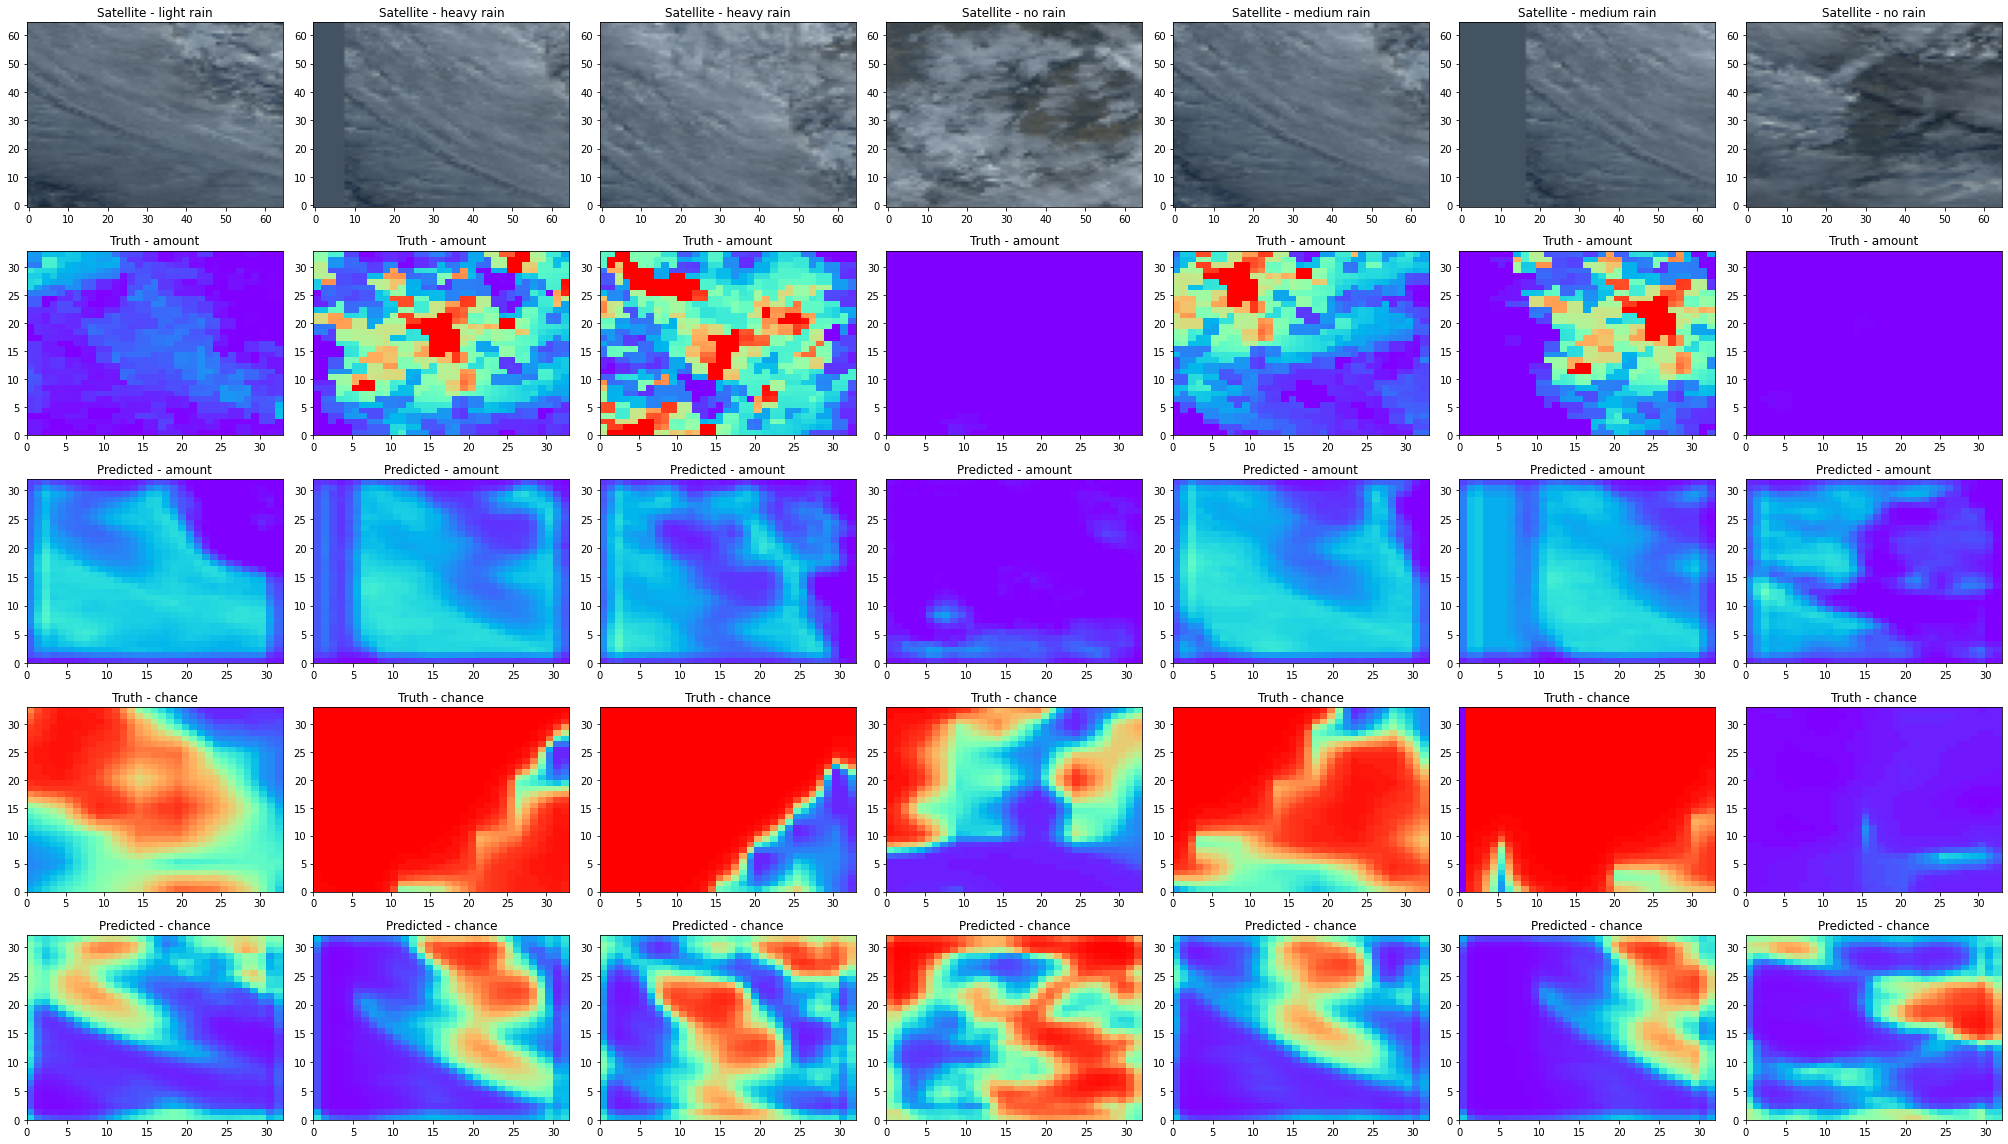

In [12]:
import matplotlib.pyplot as plt

# Setup a 3 row plot grid.
n = len(test_truths)
fig = plt.figure(figsize=(n*4, 16))
i = 1

def transform_goes_bands_display(array):
  BAND_SCALE_MULTIPLIER = 0.00031746001
  blue = array[0] * BAND_SCALE_MULTIPLIER
  red = array[1] * BAND_SCALE_MULTIPLIER
  veggie = array[2] * BAND_SCALE_MULTIPLIER
  green = red*0.45 + veggie*0.10 + blue*0.45
  disp = np.array([red,green,blue])
  disp = disp/0.5
  disp = np.moveaxis(disp, 0, -1)
  return disp

for input, truth, pred, title in zip(test_inputs, test_truths, test_preds, test_titles):
  # input satellite image
  ax = plt.subplot(5,n,i)
  ax.set_title('Satellite - ' + title)
  input_disp = transform_goes_bands_display(input)
  plt.imshow(input_disp, origin='lower', aspect='auto')
  # rain amount - LABEL1
  ax = plt.subplot(5,n,i+n)
  ax.set_title('Truth - amount')
  plt.pcolormesh(truth[0], cmap='rainbow', rasterized=True, vmin=0, vmax=10)
  ax = plt.subplot(5,n,i+n+n)
  ax.set_title('Predicted - amount')
  plt.pcolormesh(pred[0], cmap='rainbow', rasterized=True, vmin=0, vmax=3)
  # rain probability - LABEL2
  ax = plt.subplot(5,n,i+n+n+n)
  ax.set_title('Truth - chance')
  plt.pcolormesh(truth[1], cmap='rainbow', rasterized=True, vmin=0, vmax=100)
  ax = plt.subplot(5,n,i+n+n+n+n)  
  ax.set_title('Predicted - chance')
  plt.pcolormesh(pred[1], cmap='rainbow', rasterized=True, vmin=0, vmax=1)   
  i += 1

plt.tight_layout()
plt.show()

Let's visualize the nowcasting forecast for a place in the Bay Area (CA, USA). First, we get the prediction from the model.

In [ ]:
import folium
import folium.plugins as folium_plugins
import branca.colormap as cm

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Get a prediction for the San Francisco area.
test_time = '2021-12-23T17:30:00'
location = [-122.22774047851563, 37.87459158772004]
point = ee.Geometry.Point(location[0], location[1])
timeNow = ee.Date(test_time)
trange = timeNow.getRange('minute')
gpmImage = GPM_IMAGE_COLLECTION               \
              .filter(ee.Filter.date(trange))  \
              .first()
gpmImage = gpmImage.clip(regionUSA)
rainMask = gpmImage.gt(0.5);
gpmImage = gpmImage.updateMask(rainMask);

viz_params = {
    'bands': [LABEL1],
    'min': 0,
    'max': 15.0,
    'palette': ['000096','0064ff', '00b4ff', '33db80', '9beb4a',
                'ffeb00', 'ffb300', 'ff6400', 'eb1e00', 'af0000'],
}

#empty = ee.Image().byte()
#outlines = empty.paint(featureCollection=features, color=LABEL1, width=2)
map = folium.Map(location=[location[1],location[0]], zoom_start=6, width=400,height=400)
map.add_ee_layer(gpmImage, viz_params, 'precipitation')
display(map)

# 5. 🧹 Clean Up

To **avoid incurring charges** to your Google Cloud account for the resources used in this tutorial, either delete the project that contains the resources, or keep the project and delete the individual resources.

## Deleting the project

The **easiest** way to **eliminate billing** is to delete the project that you created for the tutorial.

To delete the project:

> ⚠️ Deleting a project has the following effects:
>
> * **Everything in the project is deleted.** If you used an existing project for this tutorial, when you delete it, you also delete any other work you've done in the project.
>
> * **Custom project IDs are lost.** When you created this project, you might have created a custom project ID that you want to use in the future. To preserve the URLs that use the project ID, such as an appspot.com URL, delete selected resources inside the project instead of deleting the whole project.
>
> If you plan to explore multiple tutorials and quickstarts, **reusing** projects can help you avoid exceeding project **quota limits**.

1. In the Cloud Console, go to the **Manage resources** page.

  <button>

  [Go to Manage resources](https://console.cloud.google.com/iam-admin/projects)

  </button>

1. In the project list, select the project that you want to delete, and then click **Delete**.

1. In the dialog, type the project ID, and then click **Shut down** to delete the project.